<a href="https://colab.research.google.com/github/Exanom/Shap_ConceptDrift_examples/blob/main/MoaBigTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.io import arff
import pandas as pd
from pandas.api.types import is_numeric_dtype
import itertools
import datetime

In [26]:
f = open("contents.txt", "r")
f = f.read()
datasets = f.split("\n")

In [27]:
datasets

['AgrawalGenerator_7_5_2000_5000_10000 ',
 'AgrawalGenerator_7_5_1_5000_10000 ',
 'AgrawalGenerator_7_5_1000_5000_10000 ',
 'AgrawalGenerator_7_5_2000_3000_10000 ',
 'AgrawalGenerator_7_5_1_3000_10000 ',
 'SEAGenerator_1_3_1_5000_10000 ',
 'SEAGenerator_3_2_1_5000_10000 ',
 '']

In [28]:
def preprocess(df):
  le = preprocessing.LabelEncoder()
  for col in df.columns:
    if(not is_numeric_dtype(df[col])):
      le.fit(df[col])
      df[col]=le.transform(df[col])

In [29]:
def handle_results(columns,results,filepath=""):
  df = pd.DataFrame(results)
  df.columns = columns

  fig = plt.figure()

  ax = plt.subplot(111)
  ax.title.set_text(filepath)
  for col in df.columns:
    ax.plot(df[col], label=col, marker='o')
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  # Put a legend to the right of the current axis
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  if(filepath==""):
    plt.show()
  else:
    plt.savefig('results/'+filepath+'.png')
    plt.close()

In [68]:
def shap_analysis(x,y,model, i):
  if(i == 0):
  X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.3,
                                                	stratify =y, random_state = 13)
  start = now = datetime.datetime.now()
  model.fit(X_train,Y_train)

  print("trenowanie modelu: " + str(datetime.datetime.now() - start))
  explainer = shap.TreeExplainer(model)
  start = now = datetime.datetime.now()
  explanation = explainer(x)
  print("shap: " + str(datetime.datetime.now() - start))

  #absolute of shap values
  avg = np.abs(explanation.values)
  #average for all samples
  avg = avg.mean(0)
  #average for all classes
  avg = avg.mean(1)
  return (explanation, avg)


In [31]:
def abrupt_test(shaps):
  rep_val = []
  res = []
  for s in shaps:
    res = np.empty((len(s[0]),len(s[0][0])),float)
    for i in range(len(s[0])):
      for j in range(len(s[0][0])):
        max = np.max(s.values[:,i,j])
        min = np.min(s.values[:,i,j])
        avgs = []
        for k in range(len(s)):
          norm = (s.values[k,i,j] - min)/(max-min)
          avgs.append(norm*s.data[k,i])
        avgs = np.array(avgs)
        avgs = avgs.mean()
        res[i][j] = avgs
    rep_val.append(res)
  return rep_val

In [32]:
def handle_abrupt(rep_val, X, Y, filepath=''):
  features = X.columns
  classes = Y.unique()
  rep_val = np.array(rep_val)

  fig = plt.figure()
  ax = plt.subplot(111)
  ax.title.set_text(filepath)
  for i in range(len(rep_val[0])):
    for j in range(len(rep_val[0][0])):
      name = str(features[i]) + '_' + str(classes[j])
      ax.plot(rep_val[:,i,j], label=name, marker='o')

  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  if(filepath==""):
    plt.show()
  else:
    plt.savefig('results/'+filepath+'_abrupt.png')
    plt.close()

In [64]:
def analyze(filepath,sample_count,batch_size):
  if(sample_count%batch_size != 0):
    print("incorrect setup")
    return

  #load
  if(filepath==''):
    return
  data = arff.loadarff(filepath + '.arff')
  df = pd.DataFrame(data[0])

  preprocess(df)

  model = RandomForestClassifier()

  Y = df['class']
  X = df.drop('class',axis=1)


  shaps_avgs = []
  shaps = []
  for i in range(round(sample_count/batch_size)):
    start = (i*batch_size)
    end = (start+batch_size)



    base, avg = shap_analysis(X[start:end],Y[start:end],model)
    shaps_avgs.append(avg)
    shaps.append(base)

  rep_val = abrupt_test(shaps)
  handle_abrupt(rep_val,X,Y,filepath)
  handle_results(df.drop('class',axis=1).columns,shaps_avgs,filepath)
  #handle_results(df.drop('class',axis=1).columns,shaps)

In [34]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [70]:

for dataset in datasets:
  if(dataset==''):
    continue

  dataset = dataset.strip()
  print(dataset)
  analyze(dataset,10000,1000)


AgrawalGenerator_7_5_2000_5000_10000
trenowanie modelu: 0:00:00.256120
shap: 0:00:00.019657
trenowanie modelu: 0:00:00.284308
shap: 0:00:00.030962
trenowanie modelu: 0:00:00.262937
shap: 0:00:00.033602
trenowanie modelu: 0:00:00.277955
shap: 0:00:00.030663
trenowanie modelu: 0:00:00.263096
shap: 0:00:00.036831
trenowanie modelu: 0:00:00.152007
shap: 0:00:00.033460
trenowanie modelu: 0:00:00.145702
shap: 0:00:00.031589
trenowanie modelu: 0:00:00.144783
shap: 0:00:00.029663
trenowanie modelu: 0:00:00.170052
shap: 0:00:00.029827
trenowanie modelu: 0:00:00.150273
shap: 0:00:00.028345
AgrawalGenerator_7_5_1_5000_10000
trenowanie modelu: 0:00:00.146440
shap: 0:00:00.013176
trenowanie modelu: 0:00:00.151613
shap: 0:00:00.018529
trenowanie modelu: 0:00:00.146646
shap: 0:00:00.017742
trenowanie modelu: 0:00:00.145871
shap: 0:00:00.017312
trenowanie modelu: 0:00:00.141473
shap: 0:00:00.017960
trenowanie modelu: 0:00:00.155662
shap: 0:00:00.026903
trenowanie modelu: 0:00:00.159156
shap: 0:00:00.0

In [36]:
import math

### Tried SeaGenerator 1 to SeaGenerator 3, but that doesn't seem to work. Our methods don't detect anything substantial, but MOA itself also doesn't note a decrease in accuracy

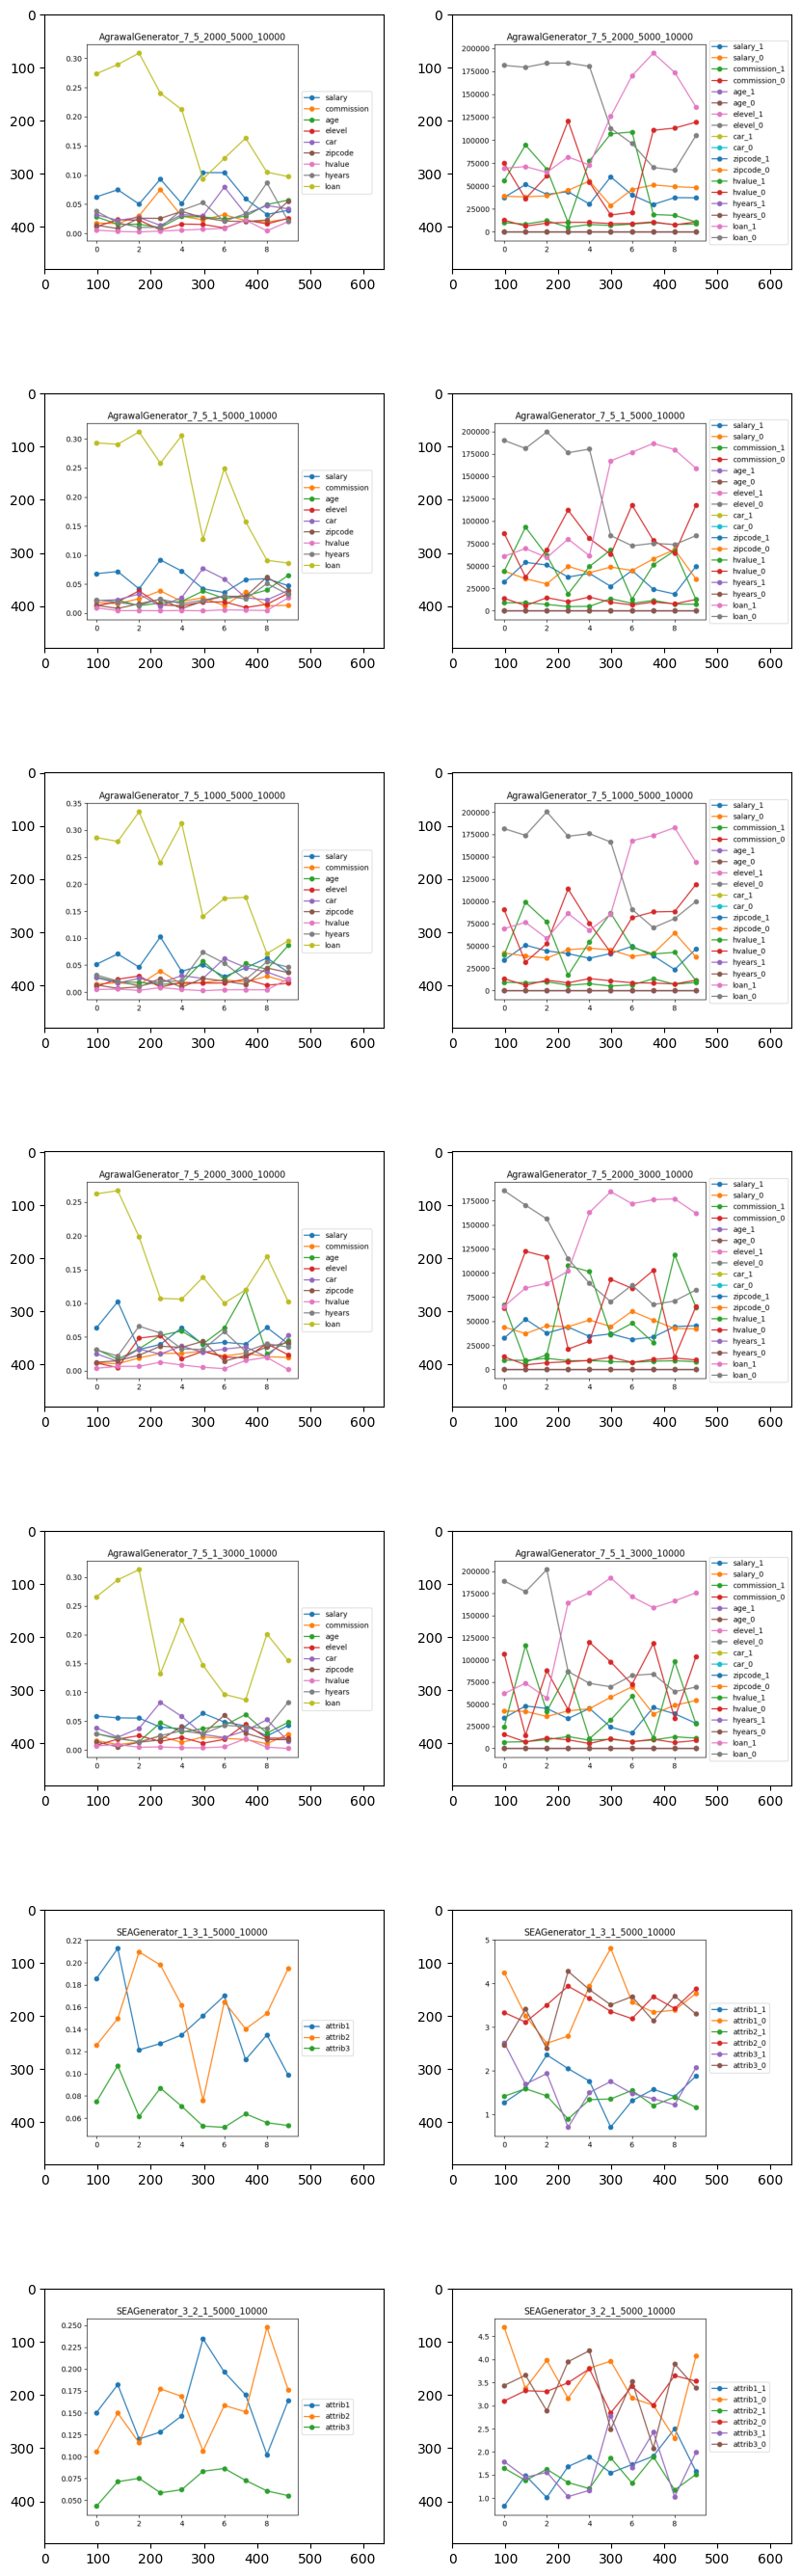

In [37]:
fig = plt.figure()
fig.set_size_inches(10,(math.ceil(len(datasets)))*5)
i = 1
for path in datasets:
  if(path==''):
    continue
  path = path.strip()
  path = 'results/'+path

  ax = plt.subplot(len(datasets),2,i)
  img = mpimg.imread(path+'.png')
  ax.imshow(img)

  ax = plt.subplot(len(datasets),2,i+1)
  img = mpimg.imread(path+'_abrupt.png')
  ax.imshow(img)

  i+=2
plt.savefig('results/all_results.png')

In [38]:
!zip -r results.zip results

updating: results/ (stored 0%)
updating: results/AgrawalGenerator_7_5_1_3000_10000.png (deflated 5%)
updating: results/AgrawalGenerator_7_5_1_5000_10000_abrupt.png (deflated 5%)
updating: results/AgrawalGenerator_7_5_2000_3000_10000_abrupt.png (deflated 5%)
updating: results/AgrawalGenerator_7_5_1_5000_10000.png (deflated 5%)
updating: results/SEAGenerator_1_3_1_5000_10000_abrupt.png (deflated 4%)
updating: results/all_results.png (deflated 6%)
updating: results/AgrawalGenerator_7_5_2000_5000_10000_abrupt.png (deflated 4%)
updating: results/AgrawalGenerator_7_5_2000_5000_10000.png (deflated 5%)
updating: results/AgrawalGenerator_7_5_1_3000_10000_abrupt.png (deflated 4%)
updating: results/AgrawalGenerator_7_5_1000_5000_10000_abrupt.png (deflated 5%)
updating: results/SEAGenerator_3_2_1_5000_10000_abrupt.png (deflated 3%)
updating: results/SEAGenerator_3_2_1_5000_10000.png (deflated 5%)
updating: results/SEAGenerator_1_3_1_5000_10000.png (deflated 5%)
updating: results/AgrawalGenerator_7